# Clusterng

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import hdbscan
import shapely.geometry
import geopandas as gpd

# Load NUTS Regions

In [34]:
nuts_level = 3
nuts_filepath = "data/nuts_60m.gpkg"

# Load NUTS regions
gdf_nuts = gpd.read_file(
    nuts_filepath, 
    ignore_fields=['name_latn', 'nuts_name', 'population'],
    driver='GPKG')
gdf_nuts = gdf_nuts.rename(
    columns={'cntr_code': 'country'})
gdf_nuts = gdf_nuts.set_index('nuts_id')

# Filter by NUTS level and extent
EXTENT = [-19.6,32.9,47.7,72.2]  # Europe without colonies
mask = (gdf_nuts['levl_code'] == nuts_level) \
     & gdf_nuts.within(shapely.geometry.box(*EXTENT))
gdf_nuts = gdf_nuts[mask]

gdf_nuts.head(2)

,levl_code,country,geometry
nuts_id,,,
AT111,3,AT,"MULTIPOLYGON (((16.64600 47.44700, 16.43400 47..."
AT112,3,AT,"MULTIPOLYGON (((17.16100 48.00700, 17.09300 47..."


# Load Normalized Amenity Features

In [42]:
features_filepath = "data/europe-amenity-features.csv.gz"

# Load features and fill missing values with 0
df_features = pd.read_csv(features_filepath, index_col='nuts_id').fillna(0)

# Filter by NUTS level
nuts_ids = gdf_nuts.index
df_features = df_features.loc[nuts_ids]

df_features.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,car_wash,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre
nuts_id,,,,,,,,,,,,,,,,,,,,,
AT111,0.015702,0.003691,0.006821,0.002648,0.001204,0.000053,0.000588,0.000615,0.000267,0.000053,...,0.000187,0.000000,0.000053,0.000000,0.000481,0.00000,0.000080,0.000000,0.000053,0.000053
AT112,0.021054,0.004030,0.003249,0.003617,0.001056,0.000375,0.000637,0.001018,0.000812,0.000494,...,0.000344,0.000012,0.000031,0.000006,0.000069,0.00005,0.000312,0.000125,0.000131,0.000100


In [43]:
mask = ~df_features.isna().all(axis=1)
df_features = df_features[mask]
df_features = df_features.applymap(
    lambda x: np.log10(x * 100_000) if x > 0 else -2)

# Calculate K-Means Clusters

In [44]:
from sklearn import cluster

clustering = cluster.KMeans(n_clusters=7, random_state=0)
clustering.fit(df_features.values)

KMeans(n_clusters=7, random_state=0)

In [46]:
df_features['labels'] = [
    f"Label {label}" for label in clustering.labels_
]
df_features.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre,labels
nuts_id,,,,,,,,,,,,,,,,,,,,,
AT111,3.195952,2.567193,2.833854,2.422949,2.080527,0.728344,1.769737,1.789042,1.427314,0.728344,...,-2.000000,0.728344,-2.000000,1.682587,-2.000000,0.904435,-2.000000,0.728344,0.728344,Label 2
AT112,3.323336,2.605266,2.511710,2.558385,2.023593,1.573858,1.804307,2.007894,1.909650,1.693333,...,0.096736,0.494676,-0.204294,0.837099,0.698796,1.494676,1.096736,1.117926,0.999826,Label 2


# Visualize K-Means Clusters

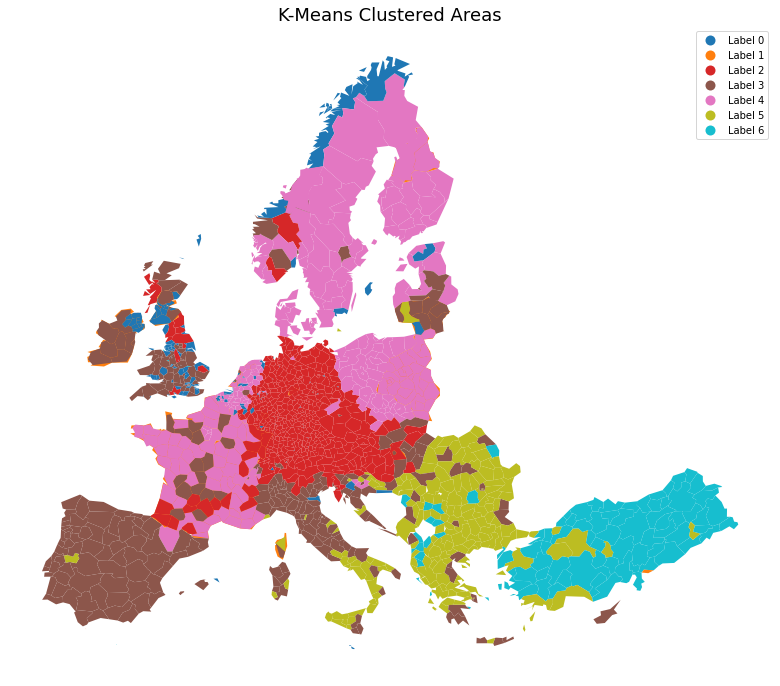

In [47]:
fig, ax = plt.subplots(figsize=(16, 12)) 

gdf_nuts.join(df_features['labels'], how='inner').to_crs(epsg=3035).plot(
    ax=ax,
    legend=True,
    linewidth=0.2,
    categorical=True,
    column='labels');

ax.set_title("K-Means Clustered Areas", fontsize=18)
ax.set_axis_off();

# Calculate HDBSCAN Clusters

In [14]:
X = df_features.set_index('nuts_id').values

In [55]:
df_features = df_features.drop(columns=['labels'])

In [56]:
clustering = hdbscan.HDBSCAN(
    min_cluster_size=5, gen_min_span_tree=True)
clustering.fit(df_features.values)

HDBSCAN(gen_min_span_tree=True)

In [57]:
df_features['labels'] = [
    f"Label {label}" for label in clustering.labels_
]
df_features.head(2)

,parking,bench,place_of_worship,restaurant,school,parking_space,fuel,waste_basket,cafe,fast_food,...,marketplace,bus_station,college,public_building,university,charging_station,bicycle_rental,veterinary,theatre,labels
nuts_id,,,,,,,,,,,,,,,,,,,,,
AT111,3.195952,2.567193,2.833854,2.422949,2.080527,0.728344,1.769737,1.789042,1.427314,0.728344,...,-2.000000,0.728344,-2.000000,1.682587,-2.000000,0.904435,-2.000000,0.728344,0.728344,Label 2
AT112,3.323336,2.605266,2.511710,2.558385,2.023593,1.573858,1.804307,2.007894,1.909650,1.693333,...,0.096736,0.494676,-0.204294,0.837099,0.698796,1.494676,1.096736,1.117926,0.999826,Label 2


# Visualize HDBSCAN Clusters

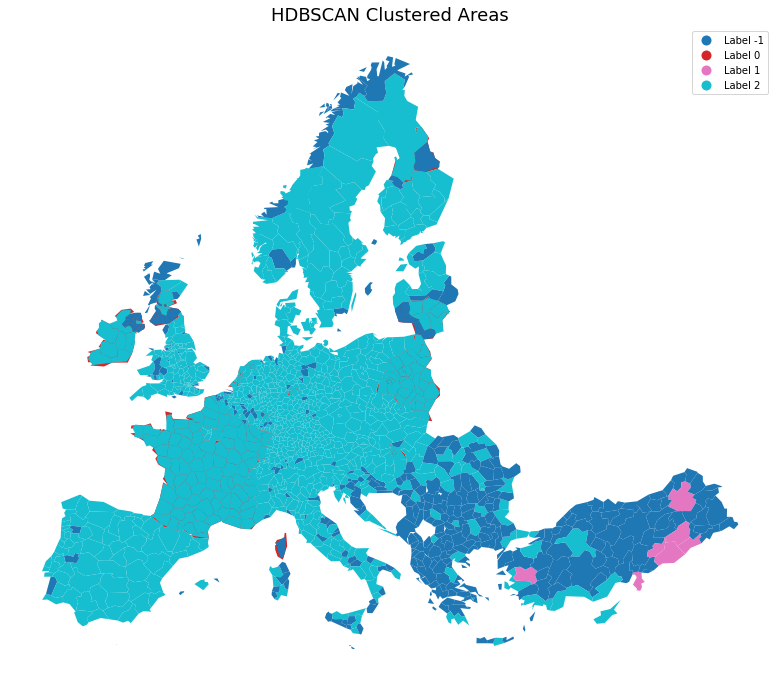

In [58]:
fig, ax = plt.subplots(figsize=(16, 12)) 

gdf_nuts.join(df_features['labels'], how='inner').to_crs(epsg=3035).plot(
    ax=ax,
    legend=True,
    linewidth=0.2,
    categorical=True,
    column='labels');

ax.set_title("HDBSCAN Clustered Areas", fontsize=18)
ax.set_axis_off();